# Data Cleaning Challenge: Imputing missing values

[Original Version by Rachael Tatman](https://www.kaggle.com/rtatman/data-cleaning-challenge-imputing-missing-values)

Welcome to Day 2 of the 5-Day Data Challenge! 

Today, we're going to be looking at how to handle missing values in R. 

Specifically, we're going to:

* Determine if your data is missing at random
* See what data is missing
* Guess (impute) the values that are missing

I'll start by introducing each concept or technique, and then you'll get a chance to apply it with an exercise (look for the **Your turn!** section). Ready? Let's get started!

___

**Kernel FAQs:**

* **How do I get started?**   To get started, click the blue "Fork Notebook" button in the upper, right hand corner. This will create a private copy of this notebook that you can edit and play with. Once you're finished with the exercises, you can choose to make your notebook public to share with others. :)

* **How do I run the code in this notebook?** Once you fork the notebook, it will open in the notebook editor. From there you can write code in any code cell (the ones with the grey background) and run the code by either 1) clicking in the code cell and then hitting CTRL + ENTER or 2) clicking in the code cell and the clicking on the white "play" arrow to the left of the cell. If you want to run all the code in your notebook, you can use the double, "fast forward" arrows at the bottom of the notebook editor.

* **How do I save my work?** Any changes you make are saved automatically as you work. You can run all the code in your notebook and save a static version by hitting the blue "Commit & Run" button in the upper right hand corner of the editor. 

* **How can I find my notebook again later?** The easiest way is to go to your user profile (https://www.kaggle.com/replace-this-with-your-username), then click on the "Kernels" tab. All of your kernels will be under the "Your Work" tab, and all the kernels you've upvoted will be under the "Favorites" tab.

___

# Get our environment set up

___

First, let's get our environment set up with all the packages and data we'll need. Make sure to run this cell in your own notebook! :)

In [1]:
options(warn=-1)

In [16]:
# read in libraries we'll use
library(tidyverse) # handy utility functions
library(mice) # package for categorical & numeric imputation
library(IRdisplay)
library(repr)

# set seed for reproducibility 
set.seed(5)

# read in our data
# 2011 Indian census data for the state of Punjab
punjab <- read_csv("all-census-data/Punjab.csv")
# Outcomes for animals taken in by Austin Animal Center
pet_data <- read_csv("austin-animal-center-shelter-outcomes-and/aac_shelter_outcomes.csv")

# seperate GDP & growth data 
punjab_gdp <- punjab %>%
    filter(Description == 'GDP (in Rs. Cr.)')
punjab_growth <- punjab %>%
    filter(Description == 'Growth Rate % (YoY)')

Parsed with column specification:
cols(
  .default = col_number(),
  Year = col_character(),
  Description = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  age_upon_outcome = col_character(),
  animal_id = col_character(),
  animal_type = col_character(),
  breed = col_character(),
  color = col_character(),
  date_of_birth = col_datetime(format = ""),
  datetime = col_datetime(format = ""),
  monthyear = col_datetime(format = ""),
  name = col_character(),
  outcome_subtype = col_character(),
  outcome_type = col_character(),
  sex_upon_outcome = col_character()
)


In [17]:
display_html("<style> 
h1, h2, h3 {text-shadow: 4px 4px 4px #aaa;} 
span {color: black; text-shadow: 4px 4px 4px #aaa;}
div.output_prompt {color: darkblue;} 
div.input_prompt {color: steelblue;} 
</style>")

# Is your data MAR (Missing At Random)?
 
___
 

The first thing to consider when you're looking at missing data is *why* it's missing. To show why this is so important, let's take a look at this dataset of information about what happened to some animals at a shelter in Austin. 

In [3]:
# print the first few rows of the pet_data dataset
t(head(pet_data))

age_upon_outcome,2 weeks,1 year,1 year,9 years,5 months,4 months
animal_id,A684346,A666430,A675708,A680386,A683115,A664462
animal_type,Cat,Dog,Dog,Dog,Other,Dog
breed,Domestic Shorthair Mix,Beagle Mix,Pit Bull,Miniature Schnauzer Mix,Bat Mix,Leonberger Mix
color,Orange Tabby,White/Brown,Blue/White,White,Brown,Brown/White
date_of_birth,2014-07-07,2012-11-06,2013-03-31,2005-06-02,2014-01-07,2013-06-03
datetime,2014-07-22 16:04:00,2013-11-07 11:47:00,2014-06-03 14:20:00,2014-06-15 15:50:00,2014-07-07 14:04:00,2013-10-07 13:06:00
monthyear,2014-07-22 16:04:00,2013-11-07 11:47:00,2014-06-03 14:20:00,2014-06-15 15:50:00,2014-07-07 14:04:00,2013-10-07 13:06:00
name,NA,Lucy,*Johnny,Monday,NA,*Edgar
outcome_subtype,Partner,Partner,NA,Partner,Rabies Risk,Partner
outcome_type,Transfer,Transfer,Adoption,Transfer,Euthanasia,Transfer


As you can see, we have some missing values in the "outcome_subtype" and "name" columns. In this instance, it wouldn't make sense to do anything with these particular missing values. For example, the name of the cat in the first row is missing. It's probably missing because it doesn't *have* a name, maybe because it's just two weeks old. The fact that the value is missing tells us something about the value. It's probably not just missing at random because someone forgot to write it down or something.

Let's look at another dataset. This file has information on the GDP (gross domestic product) of different cities in Punjab. We can see that it also has some missing values.

In [4]:
# print the first few rows of the punjab_gdp dataset
t(head(punjab_gdp))

Year,2004-05,2005-06,2006-07,2007-08,2008-09,2009-10
Description,GDP (in Rs. Cr.),GDP (in Rs. Cr.),GDP (in Rs. Cr.),GDP (in Rs. Cr.),GDP (in Rs. Cr.),GDP (in Rs. Cr.)
Amritsar,11364.41,12518.66,10051.98,11206.59,12932.01,14604.45
Barnala,NA,NA,NA,3247.54,3701.16,4248.48
Bathinda,4271.16,4854.69,5686.30,6879.18,7917.27,8727.05
Faridkot,2161.56,2458.49,2861.00,3334.75,4004.00,4351.72
Fatehgarh Sahib,2467.97,2766.16,3104.92,3812.18,4253.53,5354.42
Firozepur,6248.08,7072.82,8152.10,9590.00,11352.54,12451.43
Gurdaspur,6662.55,7618.49,8756.99,10319.26,12051.58,13463.97
Hoshiarpur,5317.82,5890.04,7042.67,8098.41,9242.03,10773.76
Jalandhar,8384.54,9506.37,11020.46,13111.98,14773.54,16709.72


In this case, these values are probably missing just because they weren't recorded for some years. It seems likely that we could make a pretty good guess about what they should be based on the rest of the data. They're (probably) not missing because of whatever the underlying value is. In this case, we can say that our data is *missing at random*.

There's no statistical way to determine if you data is missing at random or not. This is one of those cases where the solution is just to spend some time getting to know your data and how it was generated. (If you still find the distinction confusing, you're not alone! You might like [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4121561/). It's written as a little play between a medical researcher and a statistician. It's very readable.)


## Your turn!
___

Take a look at the `punjab_growth` dataset and decide if you think any values that are missing are missing at random. If you're looking for more information or practice with figuring out why data might be missing, I talk more about different types of missing data [in this notebook](https://www.kaggle.com/rtatman/data-cleaning-challenge-handling-missing-values). 

In [5]:
# your code here :)
t(head(punjab_growth))
# NA values do not look like missing at random
# maybe they were not measured

Year,2005-06,2006-07,2007-08,2008-09,2009-10,2010-11
Description,Growth Rate % (YoY),Growth Rate % (YoY),Growth Rate % (YoY),Growth Rate % (YoY),Growth Rate % (YoY),Growth Rate % (YoY)
Amritsar,10.16,-19.70,11.49,15.40,12.93,13.92
Barnala,NA,NA,NA,13.97,14.79,16.05
Bathinda,13.66,17.13,20.98,15.09,10.23,16.15
Faridkot,13.74,16.37,16.56,20.07,8.68,14.16
Fatehgarh Sahib,12.08,12.25,22.78,11.58,25.88,2.62
Firozepur,13.20,15.26,17.64,18.38,9.68,15.64
Gurdaspur,14.35,14.94,17.84,16.79,11.72,17.19
Hoshiarpur,10.76,19.57,14.99,14.12,16.57,24.14
Jalandhar,13.38,15.93,18.98,12.67,13.11,15.97


# Visualize your missing data
___

So far we've just looked at a couple of rows of our data. While this works with pretty small datasets, it doesn't scale well and it can be hard to pick out `NA`'s with your eyes. I personally  find it helpful to visualize missing values if I suspect they might exist. This can help you see how much data is missing, and also whether some particular columns or rows are very likely to have missing values. First, we need to do a little bit of data munging to get our data in the same we want it in. (If you're not familiar with the `%>%` symbol or some of these functions, I talk more about these techniques [in this notebook](https://www.kaggle.com/rtatman/manipulating-data-with-the-tidyverse/).)

In [6]:
# create a data frame with information on whether the value in each cell is missing
missing_by_column <- punjab_gdp %>% 
    is.na %>% # check if each cell is na
    as_data_frame %>% # convert to data-frame
    mutate(row_number = 1:nrow(.)) %>% # add a column with the row number
    gather(variable, is_missing, -row_number) # turn wide data into narrow data 

And now we can plot it and visually see where our data is missing! (With a shoutout to njtierney, whose [excellent color-blind friendly chart aesthetic I'm borrowing here](https://www.r-bloggers.com/ggplot-your-missing-data-2/).) 

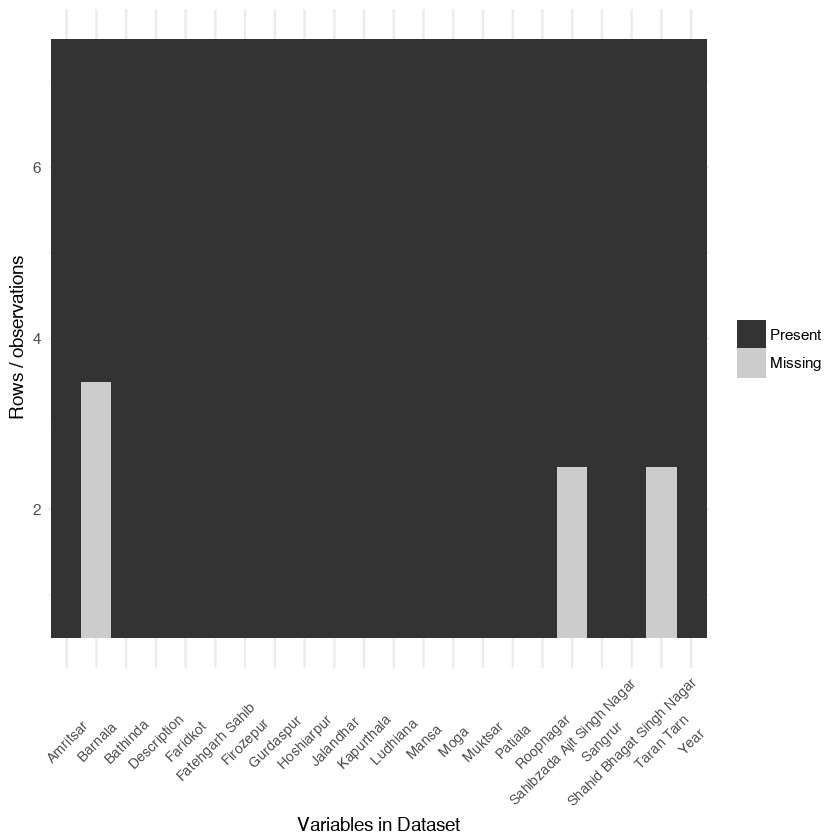

In [7]:
# Plot the missing values in our data frame, with a good-looking theme
ggplot(missing_by_column, aes(x = variable, y = row_number, fill = is_missing)) +
    geom_tile() + 
    theme_minimal() +
    scale_fill_grey(name = "",
                    labels = c("Present","Missing")) +
    theme(axis.text.x  = element_text(angle=45, vjust=0.5, size = 8)) + 
    labs(x = "Variables in Dataset",
         y = "Rows / observations")

Looking at our chart, we can see that three cities--Barnala, Sahibzada Ajit Singh Nagar and Taran Taran--all have missing data and that they overlap in which rows are missing. (Since each row is a year, this tells us that some of the same years are missing from each city). 

We can also see that our dataset is pretty small.  One way to handle missing values is to only look at "complete cases", or the rows you don't have any missing values for. In this case, though, that means that we'd lose almost a 7th of our data! In the next section, we'll discuss a  technique for filling in those missing values instead of tossing out rows. 


## Your turn!
___

Try your hand at plotting the missing values from the  `punjab_growth` dataset. Do you notice any patterns? 

In [8]:
# your code goes here! :)
# create a data frame with information on whether the value in each cell is missing
missing_by_column2 <- punjab_growth %>% 
    is.na %>% # check if each cell is na
    as_data_frame %>% # convert to data-frame
    mutate(row_number = 1:nrow(.)) %>% # add a column with the row number
    gather(variable, is_missing, -row_number) # turn wide data into narrow data 

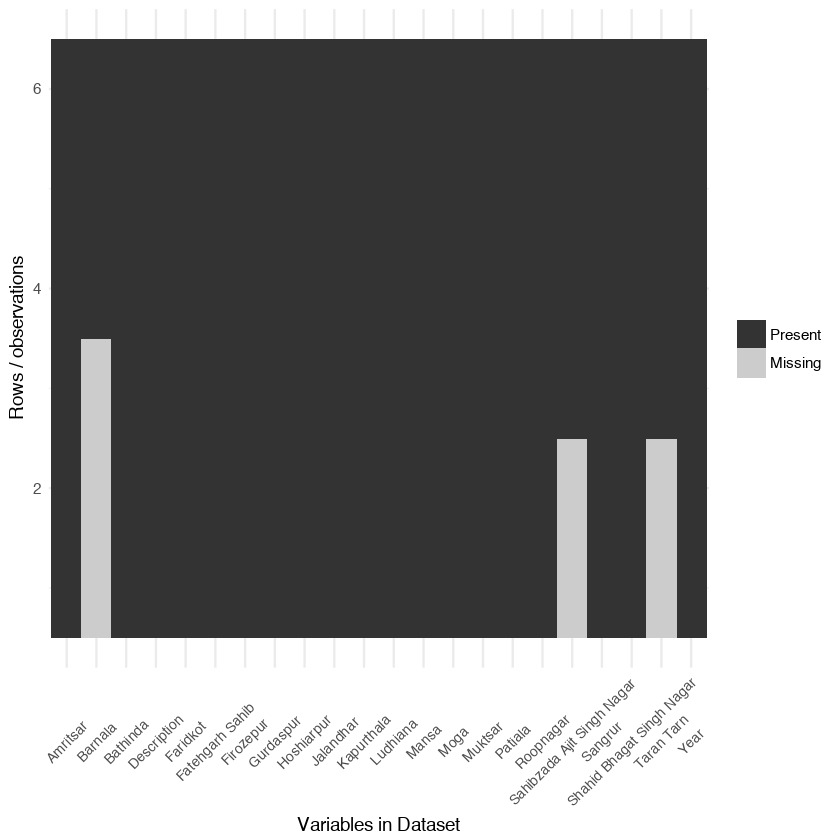

In [9]:
# Plot the missing values in our data frame, with a good-looking theme
ggplot(missing_by_column2, aes(x = variable, y = row_number, fill = is_missing)) +
    geom_tile() + 
    theme_minimal() +
    scale_fill_grey(name = "",
                    labels = c("Present","Missing")) +
    theme(axis.text.x  = element_text(angle=45, vjust=0.5, size = 8)) + 
    labs(x = "Variables in Dataset",
         y = "Rows / observations")

# Guessing what the missing values should be
___
Now that we’ve determined that we have randomly missing values, the next step is to try and figure out what they *should* be. 

> **Imputation**: The fancy math term for guessing what the value of a missing cell in your dataset should actually be. 

To do the imputation we're not going to actually look at each missing value and take our best guess. Instead, we're going to automate the process using MICE. Not the little squeaky rodents, but [Multiple Imputation by Chained Equations](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/), specifically the version implemented in [the mice R package](https://cran.r-project.org/web/packages/mice/mice.pdf). In the words of the package authors, Stef van Buuren and Karin Groothuis-Oudshoorn:  

> **The mice package implements a method to deal with missing data. The package creates multiple imputations (replacement values) for multivariate missing data. The method is based on Fully Conditional Specification, where each incomplete variable is imputed by a separate model. The MICE algorithm can impute mixes of continuous, binary, unordered categorical and ordered categorical data. In addition, MICE can impute continuous two-level data, and maintain consistency between imputations by means of passive imputation.**

Since that's a lot of math-y jargon you may or may not have run into in the past, let's break it down bit by bit so that you can get a better idea of what's going on here.

>**The package creates multiple imputations (replacement values) for multivariate missing data.**
* This basically means that, for every missing value, this function will provide several different guesses for what it could be. This gives us a better idea of the range of possible values that our variables could take. For example, if you're imputing someone's salary, your guesses may range over several thousand units. On the other hand, if you're guessing their height in feet, your guesses will probably range over a couple units. The possible range of values depends on the range of the values we *did* observe. Then, once you've imputed however-many values, you create that many different versions of your dataset and then pool across them, generally by taking the mean or median for numeric variables and the most common class for categorical variables. (If you're curious about the details, you can check out some of the papers in [this bibliography](http://www.stefvanbuuren.nl/mi/MI.html).)

>**The method is based on Fully Conditional Specification, where each incomplete variable is imputed by a separate model. **
* This means that we're going to guess the value for each missing case separately. The other common choice for imputation is called "Joint Modelling", which means that your guesses for two different variables depend on each other. For instance, if you were imputing both salary and height information for someone, with Fully Conditional Specification you'd guess one and then the other. With Joint Modeling, however, you might have reason to believe that taller people have higher salaries, and as a result might impute a higher salary if you also impute a taller height.

> **The MICE algorithm can impute mixes of continuous, binary, unordered categorical and ordered categorical data. In addition, MICE can impute continuous two-level data, and maintain consistency between imputations by means of passive imputation.**
* This bit just means that this particular function can handle pretty much any kind of data, not just numbers. This can make MICE a handy one-stop-shop for imputing all your missing data. (Assuming it's missing at random, of course.) 

Ok, now that you know the general theory, let's get to the specifics of how to actually use the function. 

There are a lot of different parameters you can tweak when using the `mice()` function. The easiest way to set them, however, is to use the parameters from an imputation run where you don’t actually do any imputation. This creates an empty model (one that doesn’t have any imputed values) with reasonable generic values. Then you can use the parameters from your empty model in a new imputation model that actually runs several times. Finally, you use the `complete()` function to pick one value for each cell you’re imputing. This gives you a copy of your original dataset with the `NA` values replaced with imputed values.

In [10]:
# initialize an empty model to take the parameters from
empty_model <- mice(punjab_gdp, maxit=0) # max iterations = 0
method <- empty_model$method
predictorMatrix <- empty_model$predictorMatrix

# first make a bunch of guesses...
imputed_data <- mice(punjab_gdp, method, predictorMatrix, m=5)
# then pick one for each variable
imputed_data <- complete(imputed_data)


 iter imp variable
  1   1  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  1   2  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  1   3  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  1   4  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  1   5  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  2   1  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  2   2  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  2   3  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  2   4  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  2   5  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  3   1  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  3   2  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  3   3  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  3   4  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  3   5  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  4   1  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  4   2  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  4   3  Ba

Let's take a look at our data to make sure it looks reasonable. 

In [11]:
# take a look at out dataset with the values imputed
t(head(imputed_data))

,1,2,3,4,5,6
Year,2004-05,2005-06,2006-07,2007-08,2008-09,2009-10
Description,GDP (in Rs. Cr.),GDP (in Rs. Cr.),GDP (in Rs. Cr.),GDP (in Rs. Cr.),GDP (in Rs. Cr.),GDP (in Rs. Cr.)
Amritsar,11364.41,12518.66,10051.98,11206.59,12932.01,14604.45
Barnala,4248.48,4930.54,3701.16,3247.54,3701.16,4248.48
Bathinda,4271.16,4854.69,5686.30,6879.18,7917.27,8727.05
Faridkot,2161.56,2458.49,2861.00,3334.75,4004.00,4351.72
Fatehgarh Sahib,2467.97,2766.16,3104.92,3812.18,4253.53,5354.42
Firozepur,6248.08,7072.82,8152.10,9590.00,11352.54,12451.43
Gurdaspur,6662.55,7618.49,8756.99,10319.26,12051.58,13463.97
Hoshiarpur,5317.82,5890.04,7042.67,8098.41,9242.03,10773.76


Looks good to me! The final step is to do a quick graph of our imputed data to make sure that we actually did get rid of all the `NA` values.

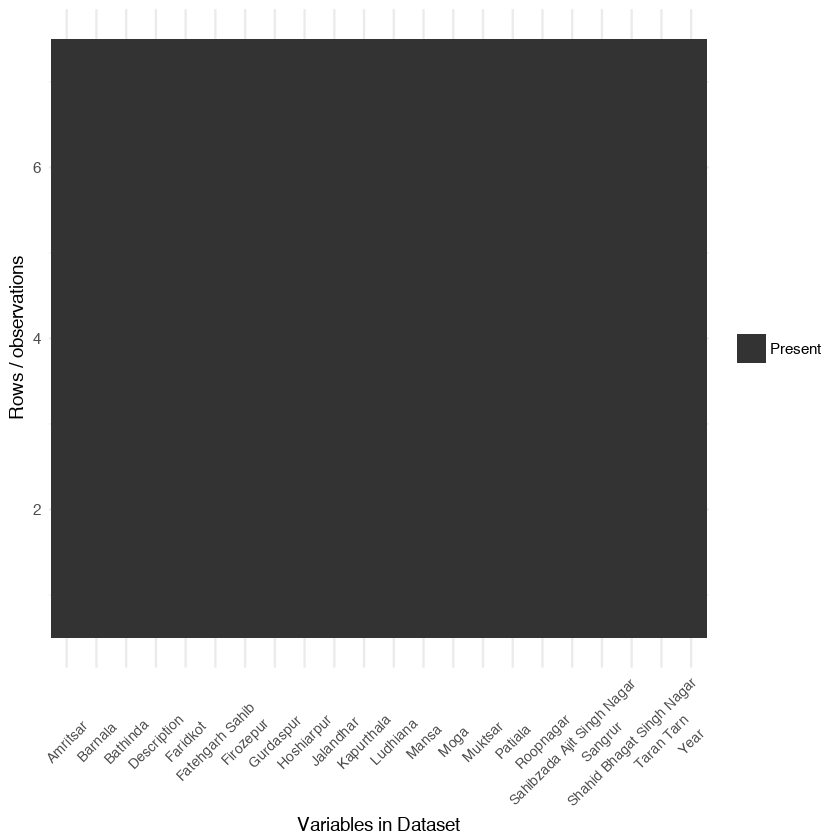

In [12]:
# create a data frame with information on whether the value in each cell is missing
missing_by_column <- imputed_data %>% 
    is.na %>% # check if each cell is na
    as_data_frame %>% # convert to data-frame
    mutate(row_number = 1:nrow(.)) %>% # add a coumn with the row number
    gather(variable, is_missing, -row_number) # turn wide data into narrow data 

# Plot the missing values in our data frame, with a good-looking theme
ggplot(missing_by_column, aes(x = variable, y = row_number, fill = is_missing)) +
    geom_tile() + 
    theme_minimal() +
    scale_fill_grey(name = "",
                    labels = c("Present","Missing")) +
    theme(axis.text.x  = element_text(angle=45, vjust=0.5, size = 8)) + 
    labs(x = "Variables in Dataset",
         y = "Rows / observations")

And all the `NA` values have been sucessfully imputed! Now try it for yourself. 

## Your turn!
____

For an extra challenge, you can spend some time investigating the various visualizations that are avalible for looking at the different imputed versions of the dataset. [This kernel has a nice introduction to some of them.](https://www.kaggle.com/captcalculator/imputing-missing-data-with-the-mice-package-in-r)

In [13]:
# your code here :)
# initialize an empty model to take the parameters from
empty_model2 <- mice(punjab_growth, maxit=0) # max iterations = 0
method2 <- empty_model2$method
predictorMatrix2 <- empty_model2$predictorMatrix

# first make a bunch of guesses...
imputed_data2 <- mice(punjab_growth, method2, predictorMatrix2, m=10)
# then pick one for each variable
imputed_data2 <- complete(imputed_data2)


 iter imp variable
  1   1  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  1   2  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  1   3  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  1   4  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  1   5  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  1   6  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  1   7  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  1   8  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  1   9  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  1   10  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  2   1  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  2   2  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  2   3  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  2   4  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  2   5  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  2   6  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  2   7  Barnala  Sahibzada Ajit Singh Nagar  Taran Tarn
  2   8  B

In [14]:
# take a look at out dataset with the values imputed
t(head(imputed_data2))

,1,2,3,4,5,6
Year,2005-06,2006-07,2007-08,2008-09,2009-10,2010-11
Description,Growth Rate % (YoY),Growth Rate % (YoY),Growth Rate % (YoY),Growth Rate % (YoY),Growth Rate % (YoY),Growth Rate % (YoY)
Amritsar,10.16,-19.70,11.49,15.40,12.93,13.92
Barnala,13.97,14.79,16.05,13.97,14.79,16.05
Bathinda,13.66,17.13,20.98,15.09,10.23,16.15
Faridkot,13.74,16.37,16.56,20.07,8.68,14.16
Fatehgarh Sahib,12.08,12.25,22.78,11.58,25.88,2.62
Firozepur,13.20,15.26,17.64,18.38,9.68,15.64
Gurdaspur,14.35,14.94,17.84,16.79,11.72,17.19
Hoshiarpur,10.76,19.57,14.99,14.12,16.57,24.14


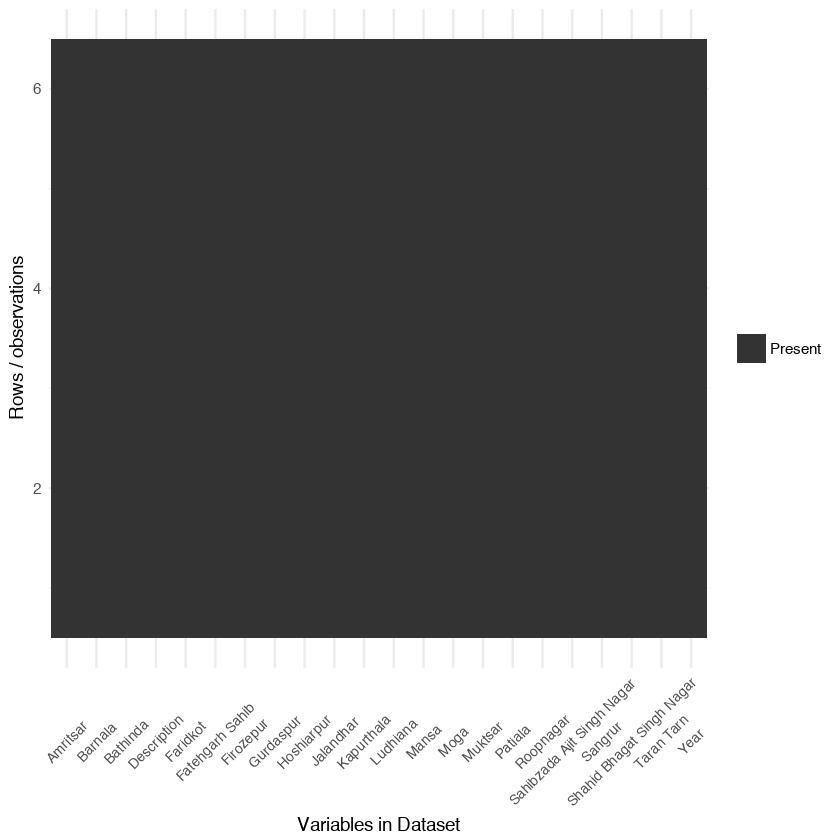

In [15]:
# create a data frame with information on whether the value in each cell is missing
missing_by_column2 <- imputed_data2 %>% 
    is.na %>% # check if each cell is na
    as_data_frame %>% # convert to data-frame
    mutate(row_number = 1:nrow(.)) %>% # add a coumn with the row number
    gather(variable, is_missing, -row_number) # turn wide data into narrow data 

# Plot the missing values in our data frame, with a good-looking theme
ggplot(missing_by_column2, aes(x = variable, y = row_number, fill = is_missing)) +
    geom_tile() + 
    theme_minimal() +
    scale_fill_grey(name = "",
                    labels = c("Present","Missing")) +
    theme(axis.text.x  = element_text(angle=45, vjust=0.5, size = 8)) + 
    labs(x = "Variables in Dataset",
         y = "Rows / observations")

# And that's it for Day 2!
___

And that's it for today! If you have any questions, be sure to post them in the comments below or [on the forums](https://www.kaggle.com/questions-and-answers).

Remember that your notebook is private by default, and in order to share it with other people or ask for help with it, you'll need to make it public. First, you'll need to save a version of your notebook that shows your current work by hitting the "Commit & Run" button. (Your work is saved automatically, but versioning your work lets you go back and look at what it was like at the point you saved it. It also lets you share a nice compiled notebook instead of just the raw code.) Then, once your notebook is finished running, you can go to the Settings tab in the panel to the left (you may have to expand it by hitting the [<] button next to the "Commit & Run" button) and setting the "Visibility" dropdown to "Public".